**問題（結果出錯)：**

1.多次更新，最後的cost為什麼不是cost_hist?不是已經被加進cost_hist了嗎？

2.最後測試階段是哪裡出問題了，怎麼跑不出accuracy?反而是千位數字

colab3-1帶數學公式,colab3-2sklearn套件,5-1pytorch深度學習概念

深度學習概念：多個輸入(可以看成多元線性回歸，多個神經元)，經過sigmoind，把值凹到01之間，再加上一個b，輸出一個結果

一、定義模型

In [1]:
#先設定gpu

import pandas as pd
url="https://raw.githubusercontent.com/GrandmaCan/ML/main/Classification/Diabetes_Data.csv"
data=pd.read_csv(url)
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,男生,1
1,66,102,128.1,女生,1
2,59,65,103.9,男生,0
3,46,117,94.8,女生,0
4,45,79,57.8,男生,0
...,...,...,...,...,...
395,72,63,97.1,女生,0
396,22,117,156.7,女生,1
397,31,76,119.0,男生,0
398,36,65,96.3,女生,1


In [2]:
data["Gender"]=data["Gender"].map({"男生":1,"女生":0})
data

,Age,Weight,BloodSugar,Gender,Diabetes
0,25,119,130.8,1,1
1,66,102,128.1,0,1
2,59,65,103.9,1,0
3,46,117,94.8,0,0
4,45,79,57.8,1,0
...,...,...,...,...,...
395,72,63,97.1,0,0
396,22,117,156.7,0,1
397,31,76,119.0,1,0
398,36,65,96.3,0,1


In [3]:
#分成訓練及測試集

from sklearn.model_selection import train_test_split
#注意：多特徵要用二維矩陣格式
x=data[["Age","Weight","BloodSugar","Gender"]]
y=data["Diabetes"]
#注意：x,y切分順序(不能先y,再x)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
len(y_train)

320

In [4]:
#1
# x_train=x_train.to_numpy()
# x_test=x_test.to_numpy()

#2
# import torch
# y_train=torch.tensor(y_train.values,dtype=torch.float64)
# y_test=torch.tensor(y_test.values,dtype=torch.float64)
# x_train=torch.tensor(x_train.values,dtype=torch.float64)
# x_test=torch.tensor(x_test.values,dtype=torch.float64)

#不用先設定1,2嗎？why這兩個其中一個都沒寫，特徵縮放還是可以執行

In [5]:
#特徵縮放

#參考colab2-2。x特徵彼此差距大，讓他們縮放到相同大小，讓梯度變化一致，更穩定跟更快達到最低點
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(x_train)
x_train=scaler.transform(x_train)
x_test=scaler.transform(x_test)
x_train

array([[ 0.81523777, -0.11297982,  0.01384359,  0.93933644],
       [-1.70936951,  0.14774285, -0.26108822,  0.93933644],
       [-1.52904042,  1.36444865,  0.7322138 , -1.06458129],
       ...,
       [ 0.93545716, -0.72133273,  1.37519949,  0.93933644],
       [ 1.47644443,  0.92991087,  1.04262069, -1.06458129],
       [ 0.93545716, -0.50406383,  1.15791467,  0.93933644]])

In [6]:
#轉換成tensor
# import torch
# y_train=torch.tensor(y_train.values,dtype=torch.float64)
# y_test=torch.tensor(y_test.values,dtype=torch.float64)
# x_train=torch.tensor(x_train.values,dtype=torch.float64)
# x_test=torch.tensor(x_test.values,dtype=torㄐch.float64)


In [7]:
#定義邏輯回歸

import torch
from torch import nn
class LogisticRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    #邏輯回歸：多元線性回歸+sigmoid
    #底下的model(x_train)會發生x_train跟model資料型態不符合的error，把model改成跟x_train一樣的型態
    self.Linear_layer=nn.Linear(in_features=4,out_features=1, dtype=torch.float64)
    #找sigmoid fn。pytorch官網:左邊欄位torch.nn=>Non-linear Activations (weighted sum, nonlinearity)非線性激活函數=>nn.Sigmoid
    self.sigmoid=nn.Sigmoid()

  #定義正向傳播計算過程。參考colab4-2A
  def forward(self,x):
    return self.sigmoid(self.Linear_layer(x))


In [8]:
#創建模型

model=LogisticRegressionModel()
#state_dict()有4個w,1個b
model, model.state_dict()

(LogisticRegressionModel(
   (Linear_layer): Linear(in_features=4, out_features=1, bias=True)
   (sigmoid): Sigmoid()
 ),
 OrderedDict([('Linear_layer.weight',
               tensor([[ 0.3433,  0.2181,  0.0612, -0.0877]], dtype=torch.float64)),
              ('Linear_layer.bias', tensor([-0.3427], dtype=torch.float64))]))

In [9]:
x_train=torch.tensor(x_train,dtype=torch.float64)
x_test=torch.tensor(x_test,dtype=torch.float64)
y_train=torch.tensor(y_train.values,dtype=torch.float64)
y_test=torch.tensor(y_test.values,dtype=torch.float64)


#四個都沒加上.values,會出現以下error
#ValueError: could not determine the shape of object type 'Series'
#只有x_train,x_test是numpy，在特徵縮放的transform轉的，而另外兩個都還是pandas series物件。所以要把y_train,y_test轉成numpy再轉tensor
#上面四個轉tensor後，才有辦法在cuda上計算

In [10]:
#將model,訓練測試集資料放到gpu上

model=model.to("cuda")
x_train=x_train.to("cuda")
x_test=x_test.to("cuda")
y_train=y_train.to("cuda")
y_test=y_test.to("cuda")

#訓練測試集資料放cuda出現error。因為x_train,x_test是numpy,不能直接使用gpu,要轉換成tensor才有辦法使用
#AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [11]:
#放在gpu上後，接著就可以把資料丟到模型
model(x_train)

#RuntimeError: mat1 and mat2 must have the same dtype
#檢查資料型態
#程式碼：x_train.dtype, model.Linear_layer.weight.dtype
#model.state_dict()的result有資料型態Linear_layer.weight
#result: x_train是float64, w是float32
#定義類別那邊做資料型態修改

#輸出的值都在0-1之間，因為有經過sigmoid

tensor([[0.4579],
        [0.2698],
        [0.3937],
        [0.3565],
        [0.5468],
        [0.5574],
        [0.4784],
        [0.5530],
        [0.2819],
        [0.4907],
        [0.2518],
        [0.4689],
        [0.3264],
        [0.3337],
        [0.5002],
        [0.3831],
        [0.2495],
        [0.5694],
        [0.3376],
        [0.3936],
        [0.2927],
        [0.2767],
        [0.5665],
        [0.5051],
        [0.3715],
        [0.5782],
        [0.5533],
        [0.5278],
        [0.4979],
        [0.4608],
        [0.2024],
        [0.3725],
        [0.5789],
        [0.4371],
        [0.4355],
        [0.5142],
        [0.5707],
        [0.3404],
        [0.3491],
        [0.3181],
        [0.4519],
        [0.3322],
        [0.3875],
        [0.5302],
        [0.3336],
        [0.3331],
        [0.2637],
        [0.5065],
        [0.4296],
        [0.4963],
        [0.3498],
        [0.3099],
        [0.3636],
        [0.4551],
        [0.5522],
        [0

二、找出最佳參數 - 先設定cost_fn, optimizer

找出最佳參數前，要先定義什麼是好，什麼是不好。因此需要先設定cost function(loss function)

邏輯回歸cost function:binary cross entropy

cost=-y*log(y_pred)-(1-y)*log(1-y_pred)

在pytorch裡不用自己寫，pytorch都寫好了

pytorch官網：DOCS=>pytorch=>左邊欄位torch.nn=>loss functions=>nn.BCELoss

In [12]:
y_train=y_train.reshape(-1,1)
#y_test也會遇到same situation

#ps.dtype long, float差別
#pytorch官網搜尋dtype,可以看到int64就是long,float64是double
#課程的y_pred是float64，y_train是int64,他想要把y_train轉成float64
#y_train=y_train.type(torch.float64) or y_train=y_train.type(torch.double)

In [13]:
cost_fn=nn.BCELoss()
y_pred=model(x_train)
cost=cost_fn(y_pred,y_train)

#形狀不一樣。一個一維，一個二維
#ValueError: Using a target size (torch.Size([320])) that is different to the input size (torch.Size([320, 1])) is deprecated. Please ensure they have the same size.
#檢查程式碼：y_pred.shape,y_train.shape
#result: (torch.Size([320, 1]), torch.Size([320]))
#上面用reshape把y_train改成二維

#計算出來的cost是0.6935

print(model.state_dict())
print(cost)

OrderedDict([('Linear_layer.weight', tensor([[ 0.3433,  0.2181,  0.0612, -0.0877]], device='cuda:0',
       dtype=torch.float64)), ('Linear_layer.bias', tensor([-0.3427], device='cuda:0', dtype=torch.float64))])
tensor(0.6071, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)


In [14]:
#設定optimizer
#0.01,0.1
optimizer=torch.optim.SGD(params=model.parameters(),lr=0.1)
optimizer.zero_grad()
cost.backward()
optimizer.step()

y_pred=model(x_train)
cost=cost_fn(y_pred,y_train)

print(model.state_dict())
print(cost)

#可以看到計算梯度前，跟計算後的cost，是有下降的

OrderedDict([('Linear_layer.weight', tensor([[ 0.3386,  0.2266,  0.0898, -0.0837]], device='cuda:0',
       dtype=torch.float64)), ('Linear_layer.bias', tensor([-0.3527], device='cuda:0', dtype=torch.float64))])
tensor(0.5970, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyBackward0>)


三、找出最佳參數 - 更新多次

確定cost有在下降，可以讓他不斷更新參數

In [15]:
cost_hist=[]
train_acc_hist=[]
for epoch in range(20000):

  model.train()

  y_pred=model(x_train)
  cost=cost_fn(y_pred,y_train)
  cost_hist.append(cost.cpu().detach())
  optimizer.zero_grad()
  cost.backward()
  optimizer.step()


  #計算準確率
  #二元分類不能用相減的，要用比較
  #acc=((y_pred-y_train)/y_train)*100

  #y_train本來就是0,1(在一開始的數據，就區分出是否糖尿病),y_pred則是計算後的結果，0.XXX，所以用round取四捨五入，0.5以上就是1,
  train_acc=(torch.round(y_pred)==y_train).sum()/len(y_train)*100
  train_acc_hist.append(train_acc.cpu())

  if epoch%1000==0:
    print(f"epoch:{epoch: 6}, cost:{cost: .4e}, acc:{train_acc}%")

epoch:     0, cost: 5.9696e-01, acc:70.9375%
epoch:  1000, cost: 2.4934e-01, acc:89.375%
epoch:  2000, cost: 2.4577e-01, acc:89.0625%
epoch:  3000, cost: 2.4533e-01, acc:89.0625%
epoch:  4000, cost: 2.4525e-01, acc:89.0625%
epoch:  5000, cost: 2.4524e-01, acc:89.0625%
epoch:  6000, cost: 2.4524e-01, acc:89.0625%
epoch:  7000, cost: 2.4524e-01, acc:89.0625%
epoch:  8000, cost: 2.4524e-01, acc:89.0625%
epoch:  9000, cost: 2.4524e-01, acc:89.0625%
epoch: 10000, cost: 2.4524e-01, acc:89.0625%
epoch: 11000, cost: 2.4524e-01, acc:89.0625%
epoch: 12000, cost: 2.4524e-01, acc:89.0625%
epoch: 13000, cost: 2.4524e-01, acc:89.0625%
epoch: 14000, cost: 2.4524e-01, acc:89.0625%
epoch: 15000, cost: 2.4524e-01, acc:89.0625%
epoch: 16000, cost: 2.4524e-01, acc:89.0625%
epoch: 17000, cost: 2.4524e-01, acc:89.0625%
epoch: 18000, cost: 2.4524e-01, acc:89.0625%
epoch: 19000, cost: 2.4524e-01, acc:89.0625%


Text(0, 0.5, 'cost')

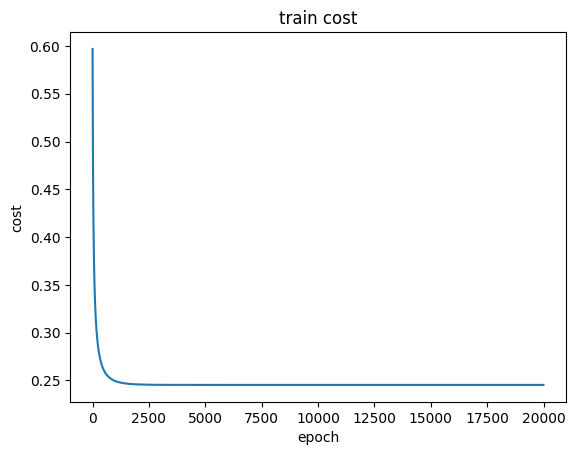

In [16]:
#繪圖
import matplotlib.pyplot as plt
plt.plot(range(0,20000),cost_hist)

#需要轉成numpy才有辦法繪圖
#TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
#cost加上.cpu()

#計算梯度會無法繪圖
#RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
#再加上detach。cost.cpu().detach()

plt.title("train cost")
plt.xlabel("epoch")
plt.ylabel("cost")

Text(0, 0.5, 'train_acc')

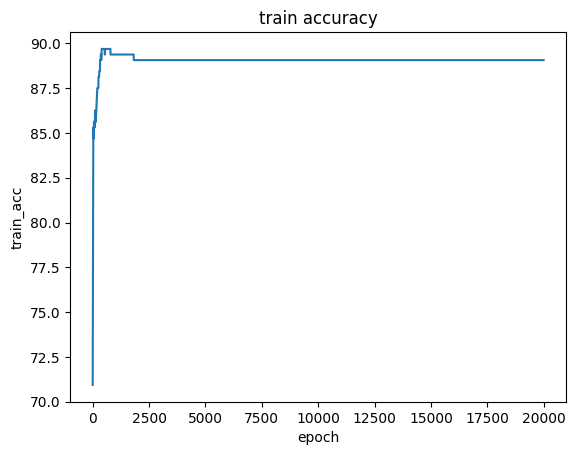

In [17]:
plt.plot(range(0,20000),train_acc_hist)
plt.title("train accuracy")
plt.xlabel("epoch")
plt.ylabel("train_acc")

#train_acc_hist.append(train_acc)加上.cpu()
#TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [18]:
#哪裡出問題了？？為什麼沒有XX.XX%
#tensor(4325., device='cuda:0')


model.eval()
with torch.inference_mode():
  test_pred=model(x_test)
  acc=(torch.round(test_pred)==y_test).sum()/len(y_test)*100
print(f"acc: {acc}%")

acc: 4420.0%


In [19]:
test_pred, y_test

(tensor([[9.7944e-01],
         [1.3451e-01],
         [4.2640e-02],
         [2.5857e-03],
         [3.4193e-03],
         [9.3846e-01],
         [1.1414e-04],
         [2.6304e-04],
         [2.1224e-01],
         [9.9258e-01],
         [9.1636e-01],
         [5.0638e-01],
         [2.9775e-02],
         [8.5494e-03],
         [9.3200e-02],
         [5.9164e-03],
         [2.9372e-04],
         [8.3862e-02],
         [9.5560e-01],
         [2.1720e-03],
         [6.7493e-01],
         [8.9497e-01],
         [8.6194e-01],
         [2.6263e-01],
         [9.4288e-05],
         [9.8712e-01],
         [8.8239e-01],
         [2.0168e-02],
         [9.9895e-01],
         [6.2811e-02],
         [1.3952e-03],
         [3.0618e-03],
         [2.8695e-01],
         [2.3968e-04],
         [5.2262e-01],
         [9.4458e-01],
         [8.9084e-01],
         [6.2103e-01],
         [9.9875e-01],
         [9.8522e-01],
         [6.9318e-02],
         [3.4486e-04],
         [2.1857e-04],
         [1

In [20]:
torch.round(test_pred)==y_test

tensor([[ True,  True, False,  ..., False,  True, False],
        [False, False,  True,  ...,  True, False,  True],
        [False, False,  True,  ...,  True, False,  True],
        ...,
        [False, False,  True,  ...,  True, False,  True],
        [ True,  True, False,  ..., False,  True, False],
        [False, False,  True,  ...,  True, False,  True]], device='cuda:0')

In [35]:
(torch.round(test_pred)==y_test)[1].sum()

tensor(52, device='cuda:0')

In [21]:
len(torch.round(test_pred)==y_test)

80

In [22]:
(torch.round(test_pred)==y_test).sum()

tensor(3536, device='cuda:0')

In [23]:
(torch.round(test_pred)==y_test).sum()

tensor(3536, device='cuda:0')

In [24]:
len(torch.round(test_pred))

80

In [25]:
torch.round(test_pred).sum()

tensor(26., device='cuda:0', dtype=torch.float64)

In [26]:
len(y_test)

80

In [27]:
y_test.sum()

tensor(28., device='cuda:0', dtype=torch.float64)